# Projekt zaliczeniowy Katarzyna Nowogórska 

## Temat 2 Przewidywanie wzięcia pożyczki

In [1]:
#Import odpowiednich pakietów oraz transformerów
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score


np.random.seed(0)

# Załadowanie danych z podanego adresu URL oraz usunięcie zmiennje LoggedIn
URL = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'
data = pd.read_csv(URL, encoding='ISO-8859–1')
data.drop(['LoggedIn'], axis=1, inplace=True)


In [2]:
#Sprawdzenie zbioru 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     87020 non-null  object 
 1   Gender                 87020 non-null  object 
 2   City                   86017 non-null  object 
 3   Monthly_Income         87020 non-null  int64  
 4   DOB                    87020 non-null  object 
 5   Lead_Creation_Date     87020 non-null  object 
 6   Loan_Amount_Applied    86949 non-null  float64
 7   Loan_Tenure_Applied    86949 non-null  float64
 8   Existing_EMI           86949 non-null  float64
 9   Employer_Name          86949 non-null  object 
 10  Salary_Account         75256 non-null  object 
 11  Mobile_Verified        87020 non-null  object 
 12  Var5                   87020 non-null  int64  
 13  Var1                   87020 non-null  object 
 14  Loan_Amount_Submitted  52407 non-null  float64
 15  Lo

### Część 1 - przekształcenia oraz wstępna analiza zmiennych

In [3]:
# Zamieniam zmienną DOB (data urodzenia) na wiek

from datetime import datetime
from datetime import date

def calculate_age(dob):
    dob = datetime.strptime(dob, "%d-%b-%y").date()
    today = date.today()
    return abs(today.year - dob.year)

data['AGE'] = data['DOB'].apply(calculate_age)
print(data['AGE']) 


# Zmienna Lead_Creation_date zamieniam na zmienna numeryczna - ile dni minęło od daty złożenia wniosku

def calculate_days(date_start):
    date_start = datetime.strptime(date_start, "%d-%b-%y").date()
    today = date.today()
    return today - date_start 

data['Days_Since_Creation'] = data['Lead_Creation_Date'].apply(calculate_days).astype('timedelta64[D]')
print(data['Days_Since_Creation']) 

0        42
1        35
2        39
3        33
4        36
         ..
87015    51
87016    30
87017    48
87018    43
87019    32
Name: AGE, Length: 87020, dtype: int64
0        2002.0
1        2013.0
2        1998.0
3        2008.0
4        1997.0
          ...  
87015    1925.0
87016    1925.0
87017    1925.0
87018    1925.0
87019    1925.0
Name: Days_Since_Creation, Length: 87020, dtype: float64


In [4]:
# Sprawdzam zmienne kategoryczne, jakie mają przypisane wartości - żeby ewentualnie skonstruować właściwe transformery
## Zmienna City

data['City'].value_counts()

#Jest dużo wartości zmiennej, ale jest kilka dużych miast, dla reszty można przypisać wspólną wartość


Delhi        12527
Bengaluru    10824
Mumbai       10795
Hyderabad     7272
Chennai       6916
             ...  
UDWADA           1
Siruguppa        1
Champawat        1
Seoni            1
Gadwal           1
Name: City, Length: 697, dtype: int64

In [5]:
##Zmienna Employer_name
data['Employer_Name'].value_counts()

#głównie 0, kilku pracodawców najbardziej popularnych 

0                                               4914
TATA CONSULTANCY SERVICES LTD (TCS)              550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     404
ACCENTURE SERVICES PVT LTD                       324
GOOGLE                                           301
                                                ... 
DIRECT INFORMATION PVT LTD                         1
COMMUNITYCOORDINATOR. IKP DRDA                     1
VERITAZ HEALTHCARE LTD                             1
JCDV                                               1
HAVEUS SOLUTIONS PVT LTD                           1
Name: Employer_Name, Length: 43567, dtype: int64

In [6]:
##Zmienna Gender 

data['Gender'].value_counts()

#0 missingów

Male      49848
Female    37172
Name: Gender, dtype: int64

In [7]:
##Zmienna Mobile_Verified  

data['Mobile_Verified'].value_counts()

# 0 missingów

Y    56481
N    30539
Name: Mobile_Verified, dtype: int64

In [8]:
##Zmienna Filled_Form  

data['Filled_Form'].value_counts()

# 0 missingów

N    67530
Y    19490
Name: Filled_Form, dtype: int64

In [9]:
##Zmienna Device_Type  

data['Device_Type'].value_counts()

# 0 missingów

Web-browser    64316
Mobile         22704
Name: Device_Type, dtype: int64

In [10]:
##Zmienna Salary_Account
data['Salary_Account'].value_counts()

#Kilka najpopularniejszych banków, zero missingów

HDFC Bank                                          17695
ICICI Bank                                         13636
State Bank of India                                11843
Axis Bank                                           8783
Citibank                                            2376
Kotak Bank                                          2067
IDBI Bank                                           1550
Punjab National Bank                                1201
Bank of India                                       1170
Bank of Baroda                                      1126
Standard Chartered Bank                              995
Canara Bank                                          990
Union Bank of India                                  951
Yes Bank                                             779
ING Vysya                                            678
Corporation bank                                     649
Indian Overseas Bank                                 612
State Bank of Hyderabad        

In [11]:
##Zmienna Var1
data['Var1'].value_counts()

#Kilka najpopularniejszych wartości

HBXX    59294
HBXC     9010
HBXB     4479
HAXA     2909
HBXA     2123
HAXB     2011
HBXD     1964
HAXC     1536
HBXH      970
HCXF      722
HAYT      508
HAVC      384
HAXM      268
HCXD      237
HCYS      217
HVYS      186
HAZD      109
HCXG       78
HAXF       15
Name: Var1, dtype: int64

In [12]:
##Zmienna Var2
data['Var2'].value_counts()

#7 wartości

B    37280
G    33032
C    14210
E     1315
D      634
F      544
A        5
Name: Var2, dtype: int64

In [13]:
##Zmienna Source
data['Source'].value_counts()

#Kilka najpopularniejszych wartości 

S122    38567
S133    29885
S159     5599
S143     4332
S127     1931
S137     1724
S134     1301
S161      769
S151      720
S157      650
S153      494
S156      308
S144      299
S158      208
S123       73
S141       57
S162       36
S124       24
S160       11
S150       10
S155        4
S138        3
S136        3
S129        3
S139        3
S135        2
S154        1
S130        1
S125        1
S140        1
Name: Source, dtype: int64

In [14]:
##Zmienna Var4
data['Var4'].value_counts() 

#8 wartosci

3    25260
1    23906
5    20266
4     6577
2     5931
0     2546
7     2302
6      232
Name: Var4, dtype: int64

Podsumowując:
Zmienne City, Employer_Name, Salary_Account, Source zostaną zamienione na zmienne numeryczne.
Zmienne Var1, Var2, Var4 zostaną wyrzucone ze zbioru. 
Reszta zmiennych kategorycznych zostanie zamieniona na dummy variables (OneHoTEncoder).

In [15]:
##Aplikacja zmian do zmiennych kategorycznych 

#Zmienna City - mapujemy 10 najczęstszych miast na zmienne 1-10, reszta będzie miała przypisane 0

cities = data["City"].value_counts().index[:10]
print(cities) 

Index(['Delhi', 'Bengaluru', 'Mumbai', 'Hyderabad', 'Chennai', 'Pune',
       'Kolkata', 'Ahmedabad', 'Jaipur', 'Gurgaon'],
      dtype='object')


In [16]:
data.loc[~data["City"].isin(cities), "City" ] = 'Other' 

cleanup_cities = {"City":     {'Other': 0, 'Delhi': 1, 'Bengaluru': 2, 'Mumbai': 3, 'Hyderabad': 4, 'Chennai': 5, 'Pune': 6,
       'Kolkata': 7, 'Ahmedabad': 8, 'Jaipur': 9, 'Gurgaon': 10}}
data.replace(cleanup_cities, inplace=True)
data.head()


,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,AGE,Days_Since_Creation
0,ID000002C20,Female,1,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,N,Web-browser,G,S122,1,0,42,2002.0
1,ID000004E40,Male,3,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,NaN,6762.9,N,Web-browser,G,S122,3,0,35,2013.0
2,ID000007H20,Male,0,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,N,Web-browser,B,S143,1,0,39,1998.0
3,ID000008I30,Male,0,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,N,Web-browser,B,S143,3,0,33,2008.0
4,ID000009J40,Male,2,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,N,Web-browser,B,S134,3,0,36,1997.0


In [17]:
#Zmienna Employer_Name - mapujemy 20 najczęstszych Employer_Name na zmienne 1-20, reszta będzie miała przypisane 0
employers = data["Employer_Name"].value_counts().index[1:20] #bo 0 będzie najwyżej
print(employers) 

Index(['TATA CONSULTANCY SERVICES LTD (TCS)',
       'COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD',
       'ACCENTURE SERVICES PVT LTD', 'GOOGLE', 'HCL TECHNOLOGIES LTD',
       'ICICI BANK LTD', 'INDIAN AIR FORCE', 'INFOSYS TECHNOLOGIES', 'GENPACT',
       'IBM CORPORATION', 'INDIAN ARMY', 'TYPE SLOWLY FOR AUTO FILL',
       'WIPRO TECHNOLOGIES', 'HDFC BANK LTD',
       'IKYA HUMAN CAPITAL SOLUTIONS LTD', 'STATE GOVERNMENT',
       'INDIAN RAILWAY', 'INDIAN NAVY', 'ARMY'],
      dtype='object')


In [18]:
data.loc[~data["Employer_Name"].isin(employers), "Employer_Name" ] = 'Other' 

cleanup_employers = {"Employer_Name":     {'Other': 0, 'TATA CONSULTANCY SERVICES LTD (TCS)': 1,
       'COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD': 2,
       'ACCENTURE SERVICES PVT LTD': 3, 'GOOGLE': 4, 'HCL TECHNOLOGIES LTD': 5,
       'ICICI BANK LTD': 6, 'INDIAN AIR FORCE': 7, 'INFOSYS TECHNOLOGIES': 8, 'GENPACT': 9,
       'IBM CORPORATION': 10, 'INDIAN ARMY': 11, 'TYPE SLOWLY FOR AUTO FILL': 12,
       'WIPRO TECHNOLOGIES': 13, 'HDFC BANK LTD': 14,
       'IKYA HUMAN CAPITAL SOLUTIONS LTD': 15, 'STATE GOVERNMENT': 16,
       'INDIAN RAILWAY': 17, 'INDIAN NAVY': 18, 'ARMY': 19, 'WIPRO BPO': 20}}
data.replace(cleanup_employers, inplace=True)
data["Employer_Name"].head()


0    0
1    1
2    0
3    0
4    0
Name: Employer_Name, dtype: int64

In [19]:
#Zmienna Salary_Account - mapujemy 10 najczęstszych Salary_Account na zmienne 1-10, reszta będzie miała przypisane 0

accounts = data["Salary_Account"].value_counts().index[:10]
print(accounts) 

Index(['HDFC Bank', 'ICICI Bank', 'State Bank of India', 'Axis Bank',
       'Citibank', 'Kotak Bank', 'IDBI Bank', 'Punjab National Bank',
       'Bank of India', 'Bank of Baroda'],
      dtype='object')


In [20]:
data.loc[~data["Salary_Account"].isin(accounts), "Salary_Account" ] = 'Other' 

cleanup_accounts = {"Salary_Account":     {'Other': 0, 'HDFC Bank': 1, 'ICICI Bank': 2, 'State Bank of India': 3, 'Axis Bank': 4,
       'Citibank':5 , 'Kotak Bank': 6, 'IDBI Bank': 7, 'Punjab National Bank': 8,
       'Bank of India': 9, 'Bank of Baroda': 10}}
data.replace(cleanup_accounts, inplace=True)
data["Salary_Account"].head()

0    1
1    2
2    3
3    3
4    1
Name: Salary_Account, dtype: int64

In [21]:
#Zmienna Source - mapujemy 10 najczęstszych Source na zmienne 1-10, reszta będzie miała przypisane 0

sources = data["Source"].value_counts().index[:10]
print(sources) 

Index(['S122', 'S133', 'S159', 'S143', 'S127', 'S137', 'S134', 'S161', 'S151',
       'S157'],
      dtype='object')


In [22]:
data.loc[~data["Source"].isin(sources), "Source" ] = 'Other' 

cleanup_sources = {"Source":     {'Other': 0, 'S122': 1, 'S133': 2, 'S159': 3, 'S143': 4, 'S127': 5, 
                                  'S137': 6, 'S134': 7, 'S161': 8, 'S151': 9, 'S157': 10}}
data.replace(cleanup_sources, inplace=True)
data["Source"].head()

0    1
1    1
2    4
3    4
4    7
Name: Source, dtype: int64

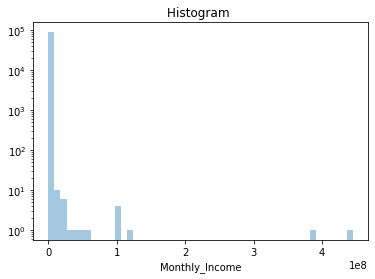

In [23]:
# Sprawdzam jak wyglądają rozkłady poszczególnych zmiennych numerycznych za pomocą wykresów 
# Na ich podstawie będzie można stwierdzić, czy niezbędne są przekształcenia pewnych zmiennych

## Zmienna Monthly_Income 

plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Monthly_Income"], hist=True, kde=False)
hist.set(title='Histogram '); 

#Rozkład prawoskośny - zostanie zastosowane przekształcenie w postaci logarytmu naturalnego

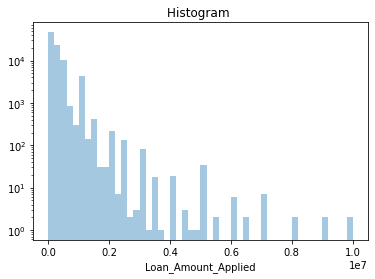

In [24]:
## Zmienna Loan_Amount_Applied 
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Loan_Amount_Applied"], hist=True, kde=False)
hist.set(title='Histogram '); 

#Rozkład prawoskośny - zostanie zaaplikowane przekształcenie w postaci logarytmu naturalnego

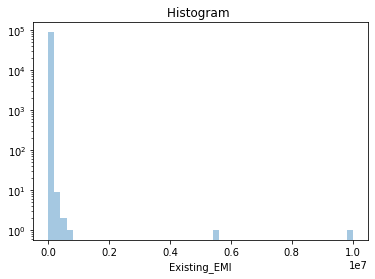

In [25]:
## Zmienna Existing_EMI   
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Existing_EMI"], hist=True, kde=False)
hist.set(title='Histogram ');  

#Rozkład prawoskośny - przekształcenie w postaci pierwiastkowania

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E610ECE250>]],
      dtype=object)

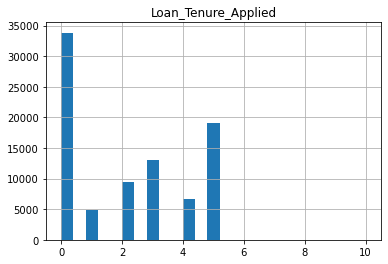

In [26]:
## Zmienna Loan_Tenure_Applied  
data.hist(column='Loan_Tenure_Applied', bins=25)

#Brak zmian

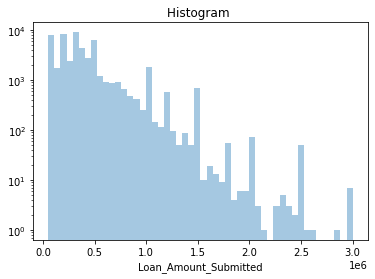

In [27]:
## Zmienna Loan_Amount_Submitted   
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Loan_Amount_Submitted"], hist=True, kde=False)
hist.set(title='Histogram '); 

#Rozkład prawoskośny - przekształcenie w postaci logarytmu naturalnego

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E6110B5310>]],
      dtype=object)

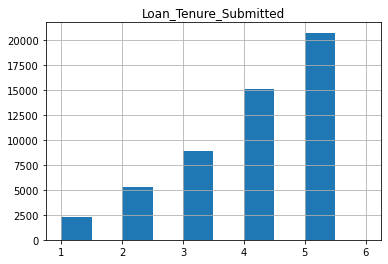

In [28]:
## Zmienna Loan_Tenure_Submitted   
data.hist(column='Loan_Tenure_Submitted')

#Nie zostanie zastosowane przekształcenie

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E611170070>]],
      dtype=object)

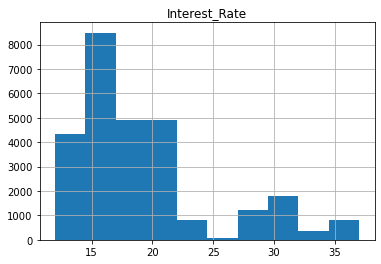

In [29]:
## Zmienna Interest_Rate   
data.hist(column='Interest_Rate')

#Nie zostanie zastosowane przekształcenie

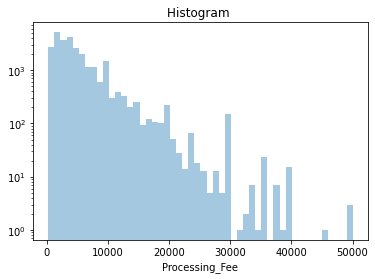

In [30]:
## Zmienna Processing_Fee   
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Processing_Fee"], hist=True, kde=False)
hist.set(title='Histogram ');  

#Rozkład prawoskośny - przekształcenie w postaci pierwiastkowania

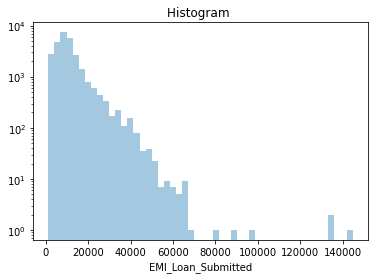

In [31]:
## Zmienna EMI_Loan_Submitted   
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["EMI_Loan_Submitted"], hist=True, kde=False)
hist.set(title='Histogram '); 

#Rozkład prawoskośny - pierwiastkowanie

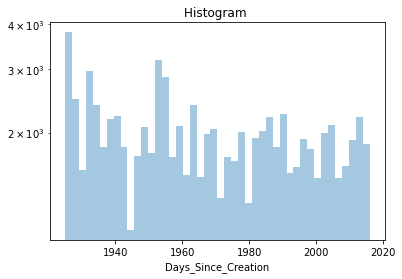

In [32]:
## Zmienna Days_Since_Creation   
plt.figure()
plt.yscale('log')
hist = sns.distplot(a=data["Days_Since_Creation"], hist=True, kde=False)
hist.set(title='Histogram '); 

#Brak zmian

In [33]:
## Aplikuję wszystkie transformacje 

data['Monthly_Income'] = data['Monthly_Income'].apply(np.sqrt) 

data['Loan_Amount_Applied'] = data['Loan_Amount_Applied'].apply(np.sqrt) 

data['Existing_EMI'] = data['Existing_EMI'].apply(np.sqrt) 

data['Loan_Amount_Submitted'] = data['Loan_Amount_Submitted'].apply(np.log) 

data['Processing_Fee'] = data['Processing_Fee'].apply(np.sqrt) 

data['EMI_Loan_Submitted'] = data['EMI_Loan_Submitted'].apply(np.sqrt)

data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,AGE,Days_Since_Creation
0,ID000002C20,Female,1,141.421356,23-May-78,15-May-15,547.722558,5.0,0.000000,0,...,NaN,NaN,N,Web-browser,G,1,1,0,42,2002.0
1,ID000004E40,Male,3,187.082869,07-Oct-85,04-May-15,447.213595,2.0,0.000000,1,...,NaN,82.236853,N,Web-browser,G,1,3,0,35,2013.0
2,ID000007H20,Male,0,150.000000,10-Oct-81,19-May-15,774.596669,4.0,0.000000,0,...,NaN,NaN,N,Web-browser,B,4,1,0,39,1998.0
3,ID000008I30,Male,0,187.082869,30-Nov-87,09-May-15,1000.000000,5.0,0.000000,0,...,NaN,NaN,N,Web-browser,B,4,3,0,33,2008.0
4,ID000009J40,Male,2,316.227766,17-Feb-84,20-May-15,707.106781,2.0,158.113883,0,...,NaN,NaN,N,Web-browser,B,7,3,0,36,1997.0


# Część 2 - konstrukcja pipeline'ów

In [34]:
## Zaimplementowane zostaną odpowiednie transofmery, które pozwolą na wybranie odpowiednich zmiennych ze zbioru 
##oraz ich przekształcenia 

# Transformer DropColumns, za pomocą którego będzie można usunąć zbędne kolumny

class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    
    def __init__(self, columns):
        self.columns_to_drop = columns
                    
    def fit(self, X, y=None):
        # nieużywana metoda
        return self

    def transform(self, X):
        return X.drop(labels=self.columns_to_drop, 
                      axis=1, 
                      inplace=False)

# Transformer ColumnsSelectorByType wybierający zmienne o odpowiednim typie (numeryczne, kategoryczne)

class ColumnsSelectorByType(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns by type.
    """
    
    def __init__(self, column_types):
        self.selected_column_types = column_types
                    
    def fit(self, X, y=None):
        # nieużywana metoda
        return self

    def transform(self, X):
        return X.select_dtypes(include=self.selected_column_types)  
    
# Transformer, który uzupełnia braki w zmiennych numerycznych wg. wybranej strategii

class SimpleImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 strategy='most_frequent', 
                 fill_value=None):
        
        self.imputer = SimpleImputer(strategy=strategy, 
                                     fill_value=fill_value)
        self.columns = None
        
    def fit(self, X, y=None):
        self.imputer.fit(X.values)
        self.columns = X.columns
        return self
        
    def transform(self, X):
        return pd.DataFrame(self.imputer.transform(X.values), columns=self.columns)

# Transformer, który który zamienia zmienne, w których ponad `treshold` procent obserwacji zawiera brak danych, 
#na zmienne binarne z wartościami 1, tam gdzie jest dana wartość oraz 0 tam, gdzie występuje brak.

class MissingIndicatorForSparseFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: float) -> None:
        # obsłuż dwa warianty podania thresholdu
        if threshold > 1:
            self.threshold = threshold/100
        else:
            self.threshold = threshold
            
        # stwórz kontener na kolumny, które zostaną przetworzone
        self.columns_to_transform = None
        
    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame=None) -> object:
        
        # wybierz indeksy kolumn, których odsetek brakujących wartości jest większy niż threshold
        columns_indicators = X.isnull().mean(axis=0) > self.threshold
        
        # zapisz odpowiednie nazwy kolumn
        self.columns_to_transform = X.columns[columns_indicators]
        
        return self
    
    def transform(self, X: pd.DataFrame)-> pd.DataFrame:
        X_transformed = X.copy()
        
        # nadpisz kolumny wartościami binarnymi
        X_transformed[self.columns_to_transform] = X_transformed[self.columns_to_transform].notnull().astype(int)
        
        return X_transformed    
    

#Transformer, który redukuje zbiór wartości zmiennych nominalnych poprzez zastępowanie wartości 
#występujących w mniej niż treshold obserwacji wartością replace_value, domyślnie równą "rare_value".  

class ReduceRareValues(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 threshold: int, 
                 replace_value: str="rare_value") -> None:
        
        self.threshold = threshold
        self.replace_value = replace_value
        
        # słownik przechowujący mapowanie kolumna -> lista częstych wartości w kolumnie
        self.classes_to_keep = {}
    
    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame=None) -> object:
        
        # dla każdej kolumny
        for column in X.columns:
            
            # sprawdź, które wartości są częstsze niż zadany threshold
            frequent_values = X[column].value_counts() >= self.threshold
            
            # pozyskaj listę indeksów (unikalnych wartości), które występują często w danej kolumnie
            values_to_keep = frequent_values[frequent_values == True].index.tolist()
            
            # dopisz do słownika wartości, które zachowasz dla danej kolumny
            self.classes_to_keep[column] = values_to_keep
        
        return self
        
        
    def transform(self, X: pd.DataFrame)-> pd.DataFrame:
        X_transformed = X.copy()
        
        # dla każdego itema w słowniku
        for column, frequent_values in self.classes_to_keep.items():
            
            # wybierz unikalne wartości z kolumny, które nie są None'ami
            unique_values = X[column][X[column].notnull()].unique()
            
            # wybierz wartości, które znajdują się w unique_values, a których nie ma w frequent_values
            values_to_replace = np.setdiff1d(unique_values, frequent_values)
            
            # jeśli są jakieś wartości do zastąpienia, zastąp wybanym szablonem
            if values_to_replace.size > 0:
                X_transformed[column].replace(values_to_replace, self.replace_value, inplace=True)
        
        return X_transformed 
    
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 with_mean: bool=True, 
                 with_std: bool=True) -> None:
        
        # pola przechowujące ustawienia scalera
        self.with_mean = with_mean
        self.with_std = with_std
        
        # zainicjalizuj pola przechowujące stastytyki
        self.means = None
        self.stds = None
        
    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame=None) -> object:
        # oblicz średnie i odchylenia standardowe
        if self.with_mean:    
            self.means = X.mean(axis=0).values 
        if self.with_std:
            self.stds = X.std(axis=0).values
        
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = X.copy()
        # przkształć zbiór zgodnie z wyliczonymi statystykami
        if self.with_mean:    
            X_transformed = X_transformed - self.means
        if self.with_std:
            X_transformed = X_transformed / self.stds
        
        return X_transformed
    
class Perf(BaseEstimator, TransformerMixin):

    def fit(self, clf, x, y, perf="auc"):

      
        y_pred_proba = clf.predict_proba(x)[:, 1]
        y_pred = clf.predict(x)
        perf_list = perf.split(',')

        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        evals = auc(fpr, tpr)


        return evals

In [35]:
numerical_features = ['AGE', 'Monthly_Income', 'Loan_Amount_Applied', 'Existing_EMI', 'Loan_Amount_Submitted',
                      'EMI_Loan_Submitted', 'City', 'Employer_Name', 'Salary_Account', 'Source']

data[numerical_features].isna().sum()

AGE                          0
Monthly_Income               0
Loan_Amount_Applied         71
Existing_EMI                71
Loan_Amount_Submitted    34613
EMI_Loan_Submitted       59294
City                         0
Employer_Name                0
Salary_Account               0
Source                       0
dtype: int64

In [36]:
categorical_features = ['Gender', 'Mobile_Verified', 'Filled_Form', 'Device_Type']
data[categorical_features].isna().sum()

Gender             0
Mobile_Verified    0
Filled_Form        0
Device_Type        0
dtype: int64

In [37]:

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='drop' # wszystkie pozostałe kolumny (niewymienione w numerical_features i categorical_features) zostają usunięte
)

clf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_lr', LogisticRegression())
])

In [38]:
clf.steps

[('prep', ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('scaler', StandardScaler())]),
                                   ['AGE', 'Monthly_Income',
                                    'Loan_Amount_Applied', 'Existing_EMI',
                                    'Loan_Amount_Submitted', 'EMI_Loan_Submitted',
                                    'City', 'Employer_Name', 'Salary_Account',
                                    'Source']),
                                  ('cat',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('one_hot',
                                                    OneHotEncoder(handle_unknown='ignore',
                  

In [39]:
X = data.drop('Disbursed', axis=1)
y = data['Disbursed'] 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
y_train.shape

(69616,)

In [42]:
X_train.shape

(69616, 26)

In [43]:
X_train

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,AGE,Days_Since_Creation
64646,ID092747F20,Male,0,393.700394,01-Aug-60,10-Jul-15,1414.213562,5.0,238.746728,0,...,15.50,92.195445,142.986748,N,Web-browser,G,1,3,40,1946.0
49973,ID071622S20,Female,0,273.861279,09-May-75,27-Jun-15,707.106781,3.0,219.089023,0,...,NaN,NaN,NaN,N,Web-browser,B,1,1,45,1959.0
48316,ID069244G40,Male,3,154.919334,01-Jun-64,24-Jun-15,316.227766,5.0,0.000000,0,...,NaN,NaN,NaN,N,Web-browser,B,1,2,44,1962.0
66078,ID094825D00,Male,0,500.000000,04-Mar-85,13-Jul-15,447.213595,4.0,0.000000,0,...,19.75,31.622777,55.042983,N,Web-browser,G,1,3,35,1943.0
68622,ID098501N10,Female,0,148.323970,21-May-87,15-Jul-15,547.722558,0.0,89.442719,0,...,NaN,NaN,NaN,N,Web-browser,G,1,7,33,1941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,ID030458M30,Male,0,122.474487,14-Sep-84,25-May-15,547.722558,3.0,0.000000,0,...,18.40,48.989795,93.406691,Y,Web-browser,B,2,5,36,1992.0
45891,ID065769P40,Male,0,173.205081,26-Apr-83,22-Jun-15,1000.000000,3.0,0.000000,0,...,NaN,NaN,NaN,N,Web-browser,B,4,2,37,1964.0
42613,ID061064Q40,Male,5,158.113883,01-Jan-70,18-Jun-15,0.000000,0.0,0.000000,0,...,NaN,NaN,NaN,N,Mobile,C,10,2,50,1968.0
43567,ID062442Q20,Male,0,122.882057,28-Nov-87,19-Jun-15,316.227766,2.0,0.000000,0,...,18.40,31.622777,70.793785,N,Web-browser,B,2,4,33,1967.0


### Początkowo nie zmieniam hiperparametrów i sprawdzam modele w ten sposób

In [44]:
clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [45]:
score1 = clf.score(X_test, y_test)
auc1 = Perf().fit(clf, X_test, y_test)

In [46]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='drop' # wszystkie pozostałe kolumny (niewymienione w numerical_features i categorical_features) zostają usunięte
)

clf2 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_dtc', DecisionTreeClassifier())
])

In [47]:
clf2.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [48]:
score2 = clf2.score(X_test, y_test)
auc2 = Perf().fit(clf2, X_test, y_test)

In [49]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='drop' # wszystkie pozostałe kolumny (niewymienione w numerical_features i categorical_features) zostają usunięte
)

clf3 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_gnb', GradientBoostingClassifier())
])

In [50]:
clf3.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [51]:
score3 =clf3.score(X_test, y_test)
auc3 = Perf().fit(clf3, X_test, y_test)

In [52]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='drop' # wszystkie pozostałe kolumny (niewymienione w numerical_features i categorical_features) zostają usunięte
)

clf4 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_rfc', RandomForestClassifier())
])

In [53]:
clf4.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [54]:
score4 = clf4.score(X_test, y_test)
auc4 = Perf().fit(clf4, X_test, y_test)

In [55]:
dc = pd.DataFrame({'Logistic_Regression' : [score1], 'DecisionTreeClassifier' : [score2], 
                   'Gradient Boosting Classifier' : [score3], 'Random Forest Classifier' : [score4]})
dc

,Logistic_Regression,DecisionTreeClassifier,Gradient Boosting Classifier,Random Forest Classifier
0,0.984716,0.966157,0.984486,0.984199


In [56]:
dc = pd.DataFrame({'Logistic_Regression' : [auc1], 'DecisionTreeClassifier' : [auc2], 
                   'Gradient Boosting Classifier' : [auc3], 'Random Forest Classifier' : [auc4]})
dc 

,Logistic_Regression,DecisionTreeClassifier,Gradient Boosting Classifier,Random Forest Classifier
0,0.750031,0.512616,0.847084,0.770376


In [57]:
params = {
'clf_lr__penalty' : ['l1', 'l2'],
    'clf_lr__C' : np.logspace(-4, 4, 20),
    'clf_lr__solver' : ['liblinear']}
clf_v2 = GridSearchCV(clf, param_grid=params) 

In [58]:
clf_fit = clf_v2.fit(X_train, y_train)

In [59]:
best_clf = clf_fit.best_estimator_
print (best_clf)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [60]:
clf_v2 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_lr', LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))
])

clf_v2.fit(X_train, y_train)
score1 = clf_v2.score(X_test, y_test)
auc1 = Perf().fit(clf_v2, X_test, y_test)

In [61]:
params = {
'clf_dtc__criterion' : ['gini', 'entropy'],
    'clf_dtc__max_depth' : range(1,10),
    'clf_dtc__min_samples_leaf' : range(1,10)}
clf2_v2 = GridSearchCV(clf2, param_grid=params) 

In [62]:
clf2_fit = clf2_v2.fit(X_train, y_train)

In [63]:
best_clf2 = clf2_fit.best_estimator_
print (best_clf2)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [64]:
clf2_v2 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_dtc', DecisionTreeClassifier(max_depth=1))
])

clf2_v2.fit(X_train, y_train)
score2 = clf2_v2.score(X_test, y_test)
auc2 = Perf().fit(clf2_v2, X_test, y_test)

In [65]:
params = {
    "clf_gnb__n_estimators":[5,50],
    "clf_gnb__max_depth":[1,3],
    "clf_gnb__learning_rate":[0.01,0.1,1,10]
}
clf3_v2 = GridSearchCV(clf3, param_grid=params) 

In [66]:
clf3_fit = clf3_v2.fit(X_train, y_train) 

In [67]:
best_clf3 = clf3_fit.best_estimator_
print (best_clf3)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [68]:
clf3_v2 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_gnb', GradientBoostingClassifier(learning_rate=0.01, max_depth=1,
                                            n_estimators=5))
])

clf3_v2.fit(X_train, y_train)

score3 = clf3_v2.score(X_test, y_test)
auc3 = Perf().fit(clf3_v2, X_test, y_test)

In [69]:
params = {
 'clf_rfc__max_depth': [10, None],
 'clf_rfc__min_samples_leaf': [1, 2],
 'clf_rfc__n_estimators': [50, 100]}
clf4_v2 = GridSearchCV(clf4, param_grid=params)

In [70]:
clf4_fit = clf4_v2.fit(X_train, y_train)

In [71]:
best_clf4 = clf4_fit.best_estimator_
print (best_clf4)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'Monthly_Income',
                                                   'Loan_Amount_Applied',
                                                   'Existing_EMI',
                                                   'Loan_Amount_Submitted',
                                                   'EMI_Loan_Submitted', 'City',
                                                   'Employer_Name',
                                                   'Salary_Account',
                                                   'Source']),

In [72]:
clf4_v2 = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf_rfc', RandomForestClassifier(max_depth=10, n_estimators=50))
])

clf4_v2.fit(X_train, y_train)

score4 = clf4_v2.score(X_test, y_test)
auc4 = Perf().fit(clf4_v2, X_test, y_test)

In [73]:
dc = pd.DataFrame({'Logistic_Regression' : [score1], 'DecisionTreeClassifier' : [score2], 
                   'Gradient Boosting Classifier' : [score3], 'Random Forest Classifier' : [score4]})
dc

,Logistic_Regression,DecisionTreeClassifier,Gradient Boosting Classifier,Random Forest Classifier
0,0.984774,0.984774,0.984774,0.984716


In [74]:
dc = pd.DataFrame({'Logistic_Regression' : [auc1], 'DecisionTreeClassifier' : [auc2], 
                   'Gradient Boosting Classifier' : [auc3], 'Random Forest Classifier' : [auc4]})
dc 

,Logistic_Regression,DecisionTreeClassifier,Gradient Boosting Classifier,Random Forest Classifier
0,0.5,0.743561,0.745382,0.837573
